**Conformal simulation (prediction intervals) in `nnetsauce` `v0.19.0`**

<span>
<a target="_blank" href="https://colab.research.google.com/github/Techtonique/nnetsauce/blob/master/nnetsauce/demo/thierrymoudiki_20240322_conformal_simulation.ipynb">
  <img style="width: inherit;" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
</span>

**Note:** In examples, [QRNN](https://thierrymoudiki.github.io/blog/#QuasiRandomizedNN) = Quasi-Randomized Nnetworks 

# **1 - Installation**

In [1]:
!pip uninstall nnetsauce --yes

Found existing installation: nnetsauce 0.20.0
Uninstalling nnetsauce-0.20.0:
  Successfully uninstalled nnetsauce-0.20.0


In [2]:
!pip install ../.. --upgrade --no-cache-dir

Processing /Users/t/Documents/Python_Packages/nnetsauce
  Preparing metadata (setup.py) ... done
  Created wheel for nnetsauce: filename=nnetsauce-0.20.0-py2.py3-none-any.whl size=165056 sha256=0fda98222bfa4919d292a766fe7cbc9c2a31237592efc794810783dd43fe9bf7
  Stored in directory: /private/var/folders/cp/q8d6040n3m38d22z3hkk1zc40000gn/T/pip-ephem-wheel-cache-t1nugz_r/wheels/1a/03/81/1cc0cae33e498e24d4eec5887a4e621a55002440ceebce517d
Successfully built nnetsauce


In [3]:
!pip install matplotlib==3.1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 1.2 MB/s eta 0:00:0000:0100:01m
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.1.3-cp311-cp311-macosx_14_0_x86_64.whl size=8459296 sha256=d2ccf4562b9f68011ffb840c11ad4f547af2c49c595d2a3aabf2ff55505a33de
  Stored in directory: /Users/t/Library/Caches/pip/wheels/12/39/7d/730cab82b77831f6a43b2732d0845e8727be9649f2357f0afd
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.4
    Uninstalling matplotlib-3.8.4:
      Successfully uninstalled matplotlib-3.8.4


In [4]:
import os 
import nnetsauce as ns 
import matplotlib.pyplot as plt 
import numpy as np 
import warnings
from sklearn.datasets import fetch_california_housing, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge, ARDRegression, RidgeCV
from sklearn.ensemble import ExtraTreesRegressor
from time import time 

# 2 - Useful plotting functions

In [5]:

warnings.filterwarnings('ignore')

split_color = 'green'
split_color2 = 'tomato'
local_color = 'gray'

def plot_func(x,
              y,
              y_u=None,
              y_l=None,
              pred=None,
              shade_color="",
              method_name="",
              title=""):

    fig = plt.figure()

    plt.plot(x, y, 'k.', alpha=.3, markersize=10,
             fillstyle='full', label=u'Test set observations')

    if (y_u is not None) and (y_l is not None):
        plt.fill(np.concatenate([x, x[::-1]]),
                 np.concatenate([y_u, y_l[::-1]]),
                 alpha=.3, fc=shade_color, ec='None',
                 label = method_name + ' Prediction interval')

    if pred is not None:
        plt.plot(x, pred, 'k--', lw=2, alpha=0.9,
                 label=u'Predicted value')

    #plt.ylim([-2.5, 7])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(loc='upper right')
    plt.title(title)

    plt.show()

# 3 - Examples of use

In [6]:
data = fetch_california_housing()
X = data.data
y= data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 123)

## RidgeCV 

In [7]:
regr1 = ns.CustomRegressor(RidgeCV(),
                           replications=50,
                           type_pi="bootstrap") # 5 hidden nodes, ReLU activation function
regr1.fit(X_train, y_train)
start = time()
preds1 = regr1.predict(X_test, method="splitconformal", return_pi=True, level=95)
print(f"Elapsed: {time() - start}s")
print(f"coverage_rate conformalized QRNN RidgeCV: {np.mean((preds1[2]<=y_test)*(preds1[3]>=y_test))}")
print(f"predictive simulations: {preds1[1]}")


100%|██████████| 50/50 [00:00<00:00, 5764.42it/s]

Elapsed: 0.485321044921875s
coverage_rate conformalized QRNN RidgeCV: 0.9636627906976745
predictive simulations: [[ 1.7645018   2.21953811  2.7577959  ...  2.95714056  2.17580939
   2.03322792]
 [ 2.21784557  1.15237351  1.29345609 ...  0.82811537  0.83008693
   2.33458989]
 [ 0.54131462  1.2599556   1.13203254 ...  1.76432143  1.78553049
   1.38434534]
 ...
 [ 0.80898131  1.13178994  0.36293712 ... -0.09959362  2.49556849
   0.19185736]
 [ 1.91398687  2.11404168  1.55327183 ...  0.98821471  1.16579251
   1.31817376]
 [ 2.6099628   4.59469828  3.25606698 ...  3.16878496  3.1704077
   2.5400101 ]]


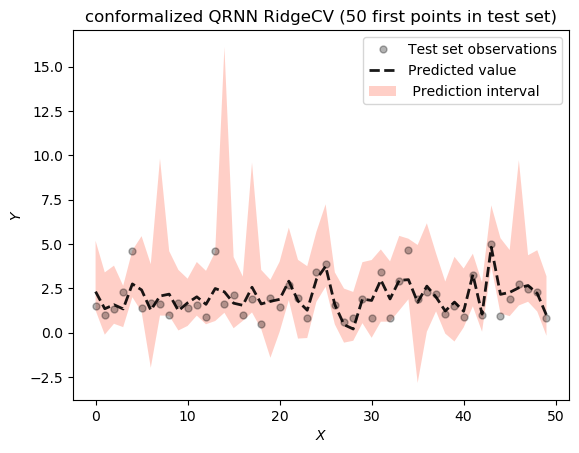

In [8]:
max_idx = 50
plot_func(x = range(max_idx),
          y = y_test[0:max_idx],
          y_u = preds1.upper[0:max_idx],
          y_l = preds1.lower[0:max_idx],
          pred = preds1.mean[0:max_idx],
          shade_color=split_color2,
          title = f"conformalized QRNN RidgeCV ({max_idx} first points in test set)")

**coverage**

In [9]:
print(np.mean((preds1[2]<=y_test)*(preds1[3]>=y_test)))

0.9636627906976745


## Extra Trees

In [10]:
regr4 = ns.CustomRegressor(ExtraTreesRegressor(),
                           replications=50,
                           type_pi="kde") # 5 hidden nodes, ReLU activation function
regr4.fit(X_train, y_train)
start = time()
preds4 = regr4.predict(X_test, method="splitconformal", return_pi=True, level=90)
print(f"Elapsed: {time() - start}s")
print(f"preds4: {preds4}")
print(f"coverage_rate conformalized QRNN ExtraTreesRegressor: {np.mean((preds4[2]<=y_test)*(preds4[3]>=y_test))}")
print(f"predictive simulations: {preds1[1]}")



100%|██████████| 50/50 [00:00<00:00, 244.89it/s]

Elapsed: 7.922621011734009s
preds4: DescribeResult(mean=array([2.01777457, 1.02634724, 1.40316164, ..., 0.87055648, 1.96978254,
       3.26367176]), sims=array([[ 1.82621303,  1.84141   ,  2.48268524, ...,  1.77841876,
         2.06031054,  2.57956291],
       [ 1.35518781,  1.25107261,  0.81659214, ...,  0.38084323,
         1.10675419,  0.87051691],
       [ 1.30911583,  0.357889  ,  1.75830405, ...,  1.49363194,
         1.38732056,  1.76493546],
       ...,
       [ 1.00185892,  0.74967648,  1.22172285, ..., -0.36238648,
         0.74253243,  0.94548377],
       [ 2.57398675,  1.98817118,  2.18824745, ...,  1.66960406,
         2.15956395,  1.32086395],
       [ 3.82975301,  2.54161116,  2.93968731, ...,  3.7345058 ,
         4.32257762,  3.56528621]]), lower=array([ 0.89186749,  0.21288458, -0.32318407, ..., -0.35697598,
        0.33447513,  1.65448797]), upper=array([2.98286028, 1.85950044, 3.43298312, ..., 2.14033392, 3.43533509,
       4.5643602 ]))
coverage_rate conformalized 

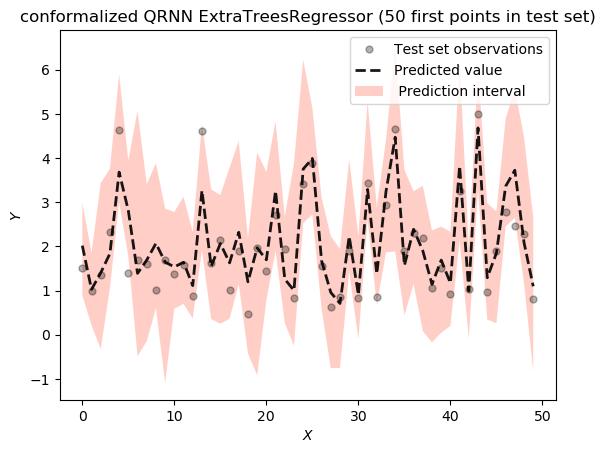

In [11]:
plot_func(x = range(max_idx),
          y = y_test[0:max_idx],
          y_u = preds4.lower[0:max_idx],
          y_l = preds4.upper[0:max_idx],
          pred = preds4.mean[0:max_idx],
          shade_color=split_color2,
          title = f"conformalized QRNN ExtraTreesRegressor ({max_idx} first points in test set)")

**coverage**

In [12]:
print(np.mean((preds4[2]<=y_test)*(preds4[3]>=y_test)))

0.9626937984496124
